In [1]:
import torch
import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.autograd.variable import Variable
import pickle
from IPython import display
from Datasets import *

In [2]:
imgsize = 56
batch_size = 16
DATA_DIR = 'Datasets/Elements/train'
IMG_DIR = os.path.join(DATA_DIR, 'Resultados/Raw')

In [3]:
fashiontransform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]
)

# fashiondata = torchvision.datasets.FashionMNIST(root=DATA_DIR, transform=fashiontransform , download=True)
fashiondata = torchvision.datasets.ImageFolder(root=DATA_DIR, transform=fashiontransform)

dataloader = DataLoader(fashiondata,batch_size=batch_size, shuffle=True)

In [4]:
img, label = fashiondata[56]

In [5]:
label

0

In [6]:
img

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [7]:
def lookat_dataset(dataset, pilimg=False):
    figure = plt.figure(figsize=(16, 4))
    rows, cols = 2, 8
    for i in range(1, 17):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.axis("off")
        if pilimg:
            plt.imshow(img)
        else:
            img = (img.squeeze() * 0.5) + 0.5
            if len(img.shape) == 2:
                plt.imshow(img, cmap='gray')
            else:
                plt.imshow(img.permute(1, 2, 0))
    plt.show()


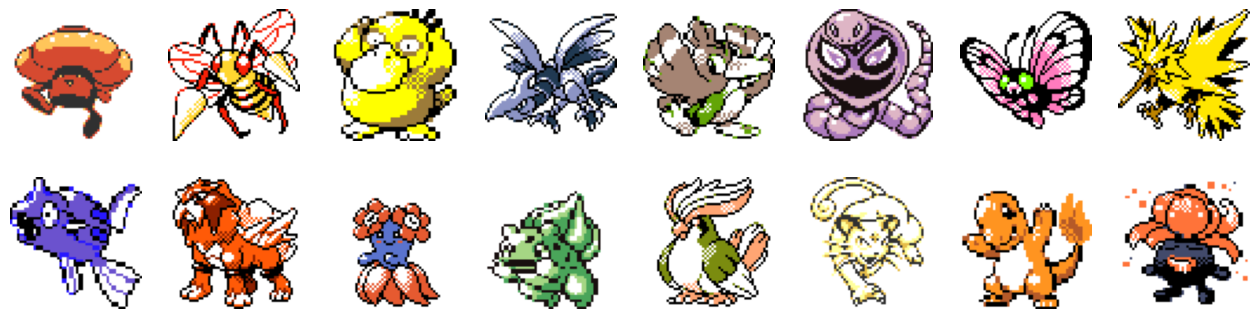

In [8]:
lookat_dataset(fashiondata)

Gerador

In [9]:
class Generator(nn.Module):
  def __init__(self, n_in, n_out):
    super().__init__()

    self.layers = nn.Sequential(
        nn.Linear(n_in, 256),
        nn.LeakyReLU(),
        nn.Linear(256, 512),
        nn.LeakyReLU(),
        nn.Linear(512, 1024),
        nn.LeakyReLU(),
        nn.Linear(1024, n_out),
        nn.Tanh()

    )

  def forward(self, z):
    return self.layers(z)

In [10]:
class Discriminator(nn.Module):
  def __init__(self, n_in):
    super().__init__()
    n_out = 1

    self.layers = nn.Sequential(
        nn.Linear(n_in, 1024),
        nn.LeakyReLU(0.2),

        nn.Linear(1024, 512),
        nn.LeakyReLU(0.2),

        nn.Linear(512, 256),
        nn.LeakyReLU(0.2),

        torch.nn.Linear(256, n_out),
        torch.nn.Sigmoid()

    )

  def forward(self, x):
    return self.layers(x)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando na {device}")

Rodando na cuda


In [12]:

noise_dim = 100
generator = Generator(noise_dim, imgsize * imgsize).to(device)
discriminator = Discriminator(imgsize * imgsize).to(device)

In [13]:
def images_to_vectors(images):
  print(images.size())
  return images.view(images.size(0), 3*imgsize * imgsize)

def vectors_to_images(vectors, nc =1):
  return vectors.view(vectors.size(0), 3 , imgsize, imgsize)

def noise(size, dim=noise_dim):
  return torch.randn(size, dim).to(device)

def log_images(test_images, savepath=None):
  figure = plt.figure(figsize=(8, 8))
  figure.subplots_adjust(wspace= -0.08, hspace=0.01)
  rows, cols = len(test_images)//4, 4
  for i, img in enumerate(test_images):
    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow(img.squeeze())

  if savepath is not None:
    figure.savefig(savepath)
  plt.show()

In [14]:
num_teste_samples = 16
torch.manual_seed(7777)
test_noise = noise(num_teste_samples,noise_dim)
imagepath = os.path.join(IMG_DIR, f'{0}.jpg')
log_images(
    vectors_to_images(
        generator(test_noise)).cpu().detach().numpy(),
    "Datasets\Resultados\Raw"
        )


<>:8: SyntaxWarning: invalid escape sequence '\R'
<>:8: SyntaxWarning: invalid escape sequence '\R'
C:\Users\arthu\AppData\Local\Temp\ipykernel_19116\3897496528.py:8: SyntaxWarning: invalid escape sequence '\R'
  "Datasets\Resultados\Raw"
C:\Users\arthu\AppData\Local\Temp\ipykernel_19116\3897496528.py:8: SyntaxWarning: invalid escape sequence '\R'
  "Datasets\Resultados\Raw"


RuntimeError: shape '[16, 3, 56, 56]' is invalid for input of size 50176

Treinamento

In [ ]:
def real_data_target(size, device=device):
  return torch.ones(size, 1).to(device)

def fake_data_target(size, device=device):
  return torch.zeros(size, 1).to(device)

In [ ]:
lr = 0.0002
g_optimizer = optim.Adam(generator.parameters(), lr = lr)

d_optimizer = optim.Adam(discriminator.parameters(), lr = lr)

loss = nn.BCELoss()


In [ ]:
def train_discriminator(optimizer, real_data, fake_data):
  optimizer.zero_grad()
    
  pred_real = discriminator(real_data)
  error_real = loss(pred_real, torch.ones_like(pred_real))
    
  pred_fake = discriminator(fake_data)
  error_fake = loss(pred_fake, torch.zeros_like(pred_fake))
    
  d_error = error_real + error_fake
  d_error.backward()
  optimizer.step()
    
  return d_error, pred_real, pred_fake

def train_generator(optimizer, fake_data):
  optimizer.zero_grad()
    
  pred_fake = discriminator(fake_data)
  g_error = loss(pred_fake, torch.ones_like(pred_fake))
    
  g_error.backward()
  optimizer.step()
    
  return g_error


In [ ]:
num_epochs = 20
G_losses = []
D_losses = []

for epoch in range(num_epochs):
  for realbatch, _ in dataloader:
    real_data = images_to_vectors(realbatch).to(device)

    fake_data = generator(noise(real_data.size(0)))

    d_error, dpred_real, dpred_fake= (
        train_discriminator(d_optimizer, real_data, fake_data)
    )

    fake_data = generator(noise(realbatch.size(0)))
    g_error = train_generator(g_optimizer, fake_data)

  imagepath = os.path.join(IMG_DIR, f'{epoch+1}.jpg')
  test_images = vectors_to_images(generator(test_noise)).cpu().detach().numpy()
  log_images(test_images, "Datasets\Resultados\Raw")

  G_losses.append(g_error)
  D_losses.append(d_error)
  print(f"Epoch: {epoch}/{num_epochs} Losses:")
  print(f"Discriminator: {d_error:.4f}; Generator: {g_error:.4f}")
  print(f"D(x): {dpred_real.mean():.4f}; D(G(z)): {dpred_fake.mean():.4f}")


<>:20: SyntaxWarning: invalid escape sequence '\R'
<>:20: SyntaxWarning: invalid escape sequence '\R'
C:\Users\arthu\AppData\Local\Temp\ipykernel_18060\4163359819.py:20: SyntaxWarning: invalid escape sequence '\R'
  log_images(test_images, "Datasets\Resultados\Raw")


torch.Size([16, 3, 56, 56])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x9408 and 3136x1024)